In [8]:
import wandb
import ast
import argparse
import os
import networkx as nx
from lineflow.helpers import get_device
from lineflow.learning.helpers import (
    make_stacked_vec_env,
)
from lineflow.learning.curriculum import CurriculumLearningCallback
from lineflow.examples import (
    MultiProcess,
    WorkerAssignment,
    ComplexLine,
    WaitingTime,
)
from sb3_contrib import (
    RecurrentPPO,
    TRPO,
)
from stable_baselines3.common.callbacks import (
    CallbackList,
    EvalCallback,
)
from stable_baselines3 import (
    PPO,
    A2C,
)
import torch_geometric as pyg
from wandb.integration.sb3 import WandbCallback

In [9]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
data = dataset[0]

In [10]:
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389],
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

In [11]:
import torch
from torch_geometric.data import HeteroData
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
data = HeteroData()

# Add nodes for authors, papers, and institutions
data['author'].x = torch.eye(3)         # 3 authors
data['paper'].x = torch.eye(2)          # 2 papers
data['institution'].x = torch.eye(2)    # 2 institutions

# Add edges
data['author', 'writes', 'paper'].edge_index = torch.tensor([
    [0, 1, 2],   # author indices
    [0, 1, 0]    # paper indices
], dtype=torch.long)

data['author', 'affiliated_with', 'institution'].edge_index = torch.tensor([
    [0, 1, 2],
    [0, 1, 0]
], dtype=torch.long)

data['institution', 'hosts', 'paper'].edge_index = torch.tensor([
    [0, 1],
    [1, 0]
], dtype=torch.long)


In [13]:
data = HeteroData()

# Add nodes for authors, papers, and institutions
data['Assembly'].x = torch.rand(1,3)     # 3 authors
data['Source'].x = torch.rand(2,4)        # 2 papers
data['Sink'].x = torch.rand(1,2) # 2 institutions

# Add edges
data['Source', 'sends', 'Assembly'].edge_index = torch.tensor([
    [0, 1],   # author indices
    [0, 0]    # paper indices
], dtype=torch.long)

data['Assembly', 'sends', 'Sink'].edge_index = torch.tensor([
    [0],
    [0]
], dtype=torch.long)



In [14]:
data = HeteroData()

# Add nodes for authors, papers, and institutions
data['Assembly'].x = torch.rand(5,5)     # 3 authors
data['Source'].x = torch.rand(1,4)        # 2 papers
data['Sink'].x = torch.rand(1,2) # 2 institutions
data['Switch'].x = torch.rand(2,3) # 2 institutions

# Add edges
data['Source', 'sends', 'Switch'].edge_index = torch.tensor([
    [0],   # author indices
    [0]    # paper indices
], dtype=torch.long)

data['Switch', 'sends', 'Assembly'].edge_index = torch.tensor([
    [0,0,0,0,0],   # author indices
    [0,1,2,3,4]    # paper indices
], dtype=torch.long)

data['Assembly', 'sends', 'Switch'].edge_index = torch.tensor([
    [0,1,2,3,4] ,
    [1,1,1,1,1]
], dtype=torch.long)

data['Switch', 'sends', 'Sink'].edge_index = torch.tensor([
    [1],   # author indices
    [0]    # paper indices
], dtype=torch.long)


In [15]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Add nodes
    for node_type in data.node_types:
        for i in range(data[node_type].num_nodes):
            G.add_node((node_type, i), node_type=node_type)

    # Add edges with types
    for edge_type in data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index
        for src, dst in zip(edge_index[0], edge_index[1]):
            G.add_edge((src_type, int(src)), (dst_type, int(dst)), key=rel_type, rel_type=rel_type)

    return G


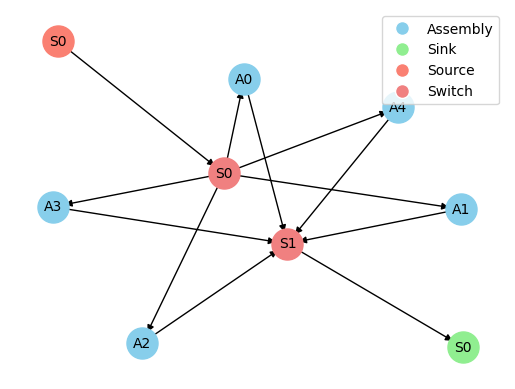

In [16]:
G = hetero_to_networkx(data)

# Layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes with type labels
node_colors = {
    'Assembly': 'skyblue',
    'Sink': 'lightgreen',
    'Source': 'salmon',
    'Switch': 'lightcoral'
}
for node_type in data.node_types:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n[0] == node_type],
        node_color=node_colors[node_type],
        label=node_type,
        node_size=500
    )

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={n: f"{n[0][0]}{n[1]}" for n in G.nodes}, font_size=10)

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Assembly', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sink', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Source', markerfacecolor='salmon', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Switch', markerfacecolor='lightcoral', markersize=10)
])
plt.axis('off')
plt.show()


In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv
from torch_geometric.data import HeteroData
from torch.nn import Linear
from torch_geometric.nn import HeteroConv, SAGEConv,TransformerConv

class MyHeteroGNN(torch.nn.Module):
    def __init__(self, metadata):
        super().__init__()

        self.conv1 = HeteroConv({
            ('Source', 'sends', 'Assembly'): TransformerConv((-1, -1), 16),
            ('Assembly', 'sends', 'Sink'): TransformerConv((-1, -1), 16),
            ('Switch', 'sends', 'Assembly'): TransformerConv((-1, -1), 16),
            ('Assembly', 'sends', 'Switch'): TransformerConv((-1, -1), 16),
            ('Switch', 'sends', 'Sink'): TransformerConv((-1, -1), 16)
        }, aggr='sum')

        self.lin = torch.nn.ModuleDict({
            node_type: Linear(16, 8) for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: self.lin[k](v) for k, v in x_dict.items()}
        return x_dict

model = MyHeteroGNN(data.metadata())  # metadata = (node_types, edge_types)
out = model(data.x_dict, data.edge_index_dict)



/home/aipexws1/miniconda3/envs/agilestem/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning: There exist node types ({'Source'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


In [18]:
out

{'Assembly': tensor([[ 0.0733,  0.1864,  0.1799, -0.2070,  0.0300, -0.0829,  0.4864,  0.2378],
         [ 0.0585,  0.1524,  0.1365, -0.2427,  0.0100, -0.0496,  0.5298,  0.2557],
         [-0.0772,  0.2374,  0.0714, -0.1683,  0.0060, -0.1688,  0.5609,  0.1462],
         [-0.0079,  0.1827,  0.1821, -0.1336, -0.0186, -0.1595,  0.5729,  0.1662],
         [-0.0693,  0.2381,  0.1400, -0.1083, -0.0144, -0.2286,  0.5582,  0.0825]],
        grad_fn=<AddmmBackward0>),
 'Switch': tensor([[-0.1068,  0.1428,  0.0693,  0.1203,  0.0512, -0.4448,  0.0294, -0.0644],
         [-0.1955,  0.0927,  0.0457, -0.0189, -0.2709, -0.2673, -0.0513,  0.1060]],
        grad_fn=<AddmmBackward0>),
 'Sink': tensor([[-0.3765,  0.0525,  0.4732, -0.5223,  0.2008,  0.0157,  0.2372,  0.2207]],
        grad_fn=<AddmmBackward0>)}

In [19]:
test_networkx = pyg.utils.to_networkx(data, to_undirected=False)

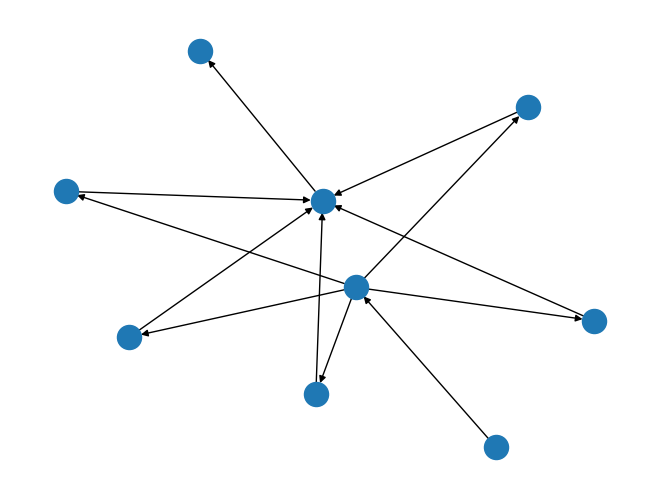

In [20]:
nx.draw(test_networkx)

### Generate using customized Class
---

In [21]:
import numpy as np
from lineflow.simulation import (
    Source,
    Sink,
    Line,
    Assembly,
)



def make_agent_fixed_waiting_time(line, waiting_time):
    waiting_times = line['S_component'].state['waiting_time'].categories

    def agent(state, env):
        """
        A policy that can effectively set float waiting times by
        alternating between ints
        """

        index = np.argmin(np.abs(waiting_times - waiting_time))
        actions = {}
        actions['S_component'] = {'waiting_time': index}
        return actions
    return agent


def compute_optimal_waiting_time(line):
    time_assembly = line['Assembly'].processing_time*1.1 + 1 + 1 + 1.1
    time_source = line['S_component'].processing_time*1.1 + 1.1
    return time_assembly-time_source


def make_optimal_agent(line):

    waiting_times = line['S_component'].state['waiting_time'].categories
    processing_time_source = line['S_component'].processing_time

    def agent(state, env):
        """
        A policy that can effectively set float waiting times by
        alternating between ints
        """
        time_assembly = state['Assembly']['processing_time'].value + 1 + 1 + 1.1
        time_source = processing_time_source*1.1 + 1.1
        waiting_time = time_assembly - time_source

        index = np.argmin(np.abs(waiting_times - waiting_time))
        actions = {}
        actions['S_component'] = {'waiting_time': index}
        return actions
    return agent


class WTAssembly(Assembly):

    def __init__(
        self,
        name,
        R=0.75,
        t_jump_max=2000,
        **kwargs,
    ):

        self.R = R
        self.t_jump_max = t_jump_max
        self.trigger_time = None
        self.factor = None

        super().__init__(name=name,  **kwargs)

    def init(self, random):
        """
        Function that is called after line is built, so all available information is present
        """
        super().init(random)

        self._sample_trigger_time()

    def _compute_scaling_factor(self, T_jump, E=3.1):

        T = self.processing_time
        S = self.processing_std
        T_sim = self.t_jump_max*2

        return 1/T*((T_jump*(T+S+E)) / ((self.R-1)*T_sim+T_jump) - S -E)


    def _sample_trigger_time(self):

        self.t_jump = np.random.uniform(
            0.8*self.t_jump_max,
            self.t_jump_max,
        )

        self.factor = self._compute_scaling_factor(self.t_jump)
        self.trigger_time = self.random.uniform(0.25, 0.75)*self.t_jump_max

    def _sample_exp_time(self, time=None, scale=None, rework_probability=0):
        """
        Samples a time from an exponential distribution
        """
        coeff = self.get_performance_coefficient()
        if self.trigger_time < self.env.now < self.trigger_time + self.t_jump:
            factor = self.factor
        else: 
            factor = 1

        return time*factor*coeff + self.random.exponential(scale=scale)



class WaitingTime(Line):
    def __init__(
        self, 
        processing_time_source=5, 
        transition_time=5, 
        with_jump=False,
        t_jump_max=None,
        assembly_condition=35,
        scrap_factor=1,
        R=0.75,
        **kwargs,
    ):
        self.processing_time_source = processing_time_source
        self.transition_time = transition_time
        self.with_jump = with_jump
        self.t_jump_max = t_jump_max
        self.assembly_condition = assembly_condition
        self.R = R
        self.components = None
        self.graph_info = None
        if self.with_jump:
            assert self.t_jump_max is not None
        super().__init__(scrap_factor=scrap_factor, **kwargs)

    def build(self):
        self.graph_info = {
            'nodes': {},
            'edges': [],
            'metadata': {}
        }
        source_main = Source(
            'S_main',
            position=(300, 300),
            processing_time=0,
            carrier_capacity=2,
            actionable_waiting_time=False,
            unlimited_carriers=True,
        )
        # Record node information
        self.graph_info['nodes']['S_main'] = {
            'type': 'Source',
            'processing_time': 0,
            'carrier_capacity': 2,
            'actionable_waiting_time': False,
            'properties': {
                'is_main_source': True,
                'controllable': False
            }
        }
        source_component = Source(
            'S_component',
            position=(500, 450),
            processing_time=self.processing_time_source,
            waiting_time=0,
            waiting_time_step=1,
            carrier_capacity=1,
            part_specs=[{
                "assembly_condition": self.assembly_condition
            }],
            unlimited_carriers=True,
            actionable_waiting_time=True,
        )
        self.graph_info['nodes']['S_component'] = {
            'type': 'Source',
            'processing_time': self.processing_time_source,
            'waiting_time': 0,
            'waiting_time_step': 1,
            'carrier_capacity': 1,
            'part_specs': [{"assembly_condition": self.assembly_condition}],
            'actionable_waiting_time': True,
            'properties': {
                'is_component_source': True,
                'controllable': True
            }
        }
        if self.with_jump:
            assembly = WTAssembly(
                'Assembly',
                t_jump_max=self.t_jump_max,
                position=(500, 300),
                R=self.R,
                processing_time=20,
                NOK_part_error_time=5,
            )
            self.graph_info['nodes']['Assembly'] = {
                'type': 'WTAssembly',
                'processing_time': 20,
                'NOK_part_error_time': 5,
                't_jump_max': self.t_jump_max,
                'R': self.R,
                'properties': {
                    'has_jump_behavior': True,
                    'is_assembly': True
                }
            }
        else:
            assembly = Assembly(
                'Assembly',
                position=(500, 300),
                processing_time=20,
                NOK_part_error_time=5,
            )
            self.graph_info['nodes']['Assembly'] = {
                'type': 'Assembly',
                'processing_time': 20,
                'NOK_part_error_time': 5,
                'properties': {
                    'has_jump_behavior': False,
                    'is_assembly': True
                }
            }


        sink = Sink('Sink', processing_time=0, position=(700, 300))
        self.graph_info['nodes']['Sink'] = {
            'type': 'Sink',
            'processing_time': 0,
            'properties': {
                'is_sink': True
            }
        }
        assembly.connect_to_component_input(
            station=source_component,
            capacity=3,
            transition_time=self.transition_time,
        )
        self.graph_info['edges'].append({
            'source': 'S_component',
            'target': 'Assembly',
            'connection_type': 'component_input',
            'capacity': 3,
            'transition_time': self.transition_time,
            'properties': {
                'is_component_feed': True
            }
        })
        assembly.connect_to_input(source_main, capacity=2, transition_time=2)
        self.graph_info['edges'].append({
            'source': 'S_main',
            'target': 'Assembly',
            'connection_type': 'standard_input',
            'capacity': 2,
            'transition_time': 2,
            'properties': {
                'is_main_feed': True
            }
        })
        
        sink.connect_to_input(assembly, capacity=2, transition_time=2)

        self.graph_info['edges'].append({
            'source': 'Assembly',
            'target': 'Sink',
            'connection_type': 'standard_input',
            'capacity': 2,
            'transition_time': 2,
            'properties': {
                'is_output': True
            }
        })


In [22]:
def build_graph_from_info(graph_info, output_format='dict'):
    """
    Reconstruct graph from recorded graph_info
    """
    if output_format == 'networkx':
        import networkx as nx
        G = nx.DiGraph()
        
        # Add nodes with attributes
        for node_name, node_data in graph_info['nodes'].items():
            G.add_node(node_name, **node_data)
        
        # Add edges with attributes
        for edge_data in graph_info['edges']:
            G.add_edge(
                edge_data['source'], 
                edge_data['target'],
                **{k: v for k, v in edge_data.items() if k not in ['source', 'target']}
            )
        
        return G
    
    elif output_format == 'heterodata':
        from torch_geometric.data import HeteroData
        import torch
        
        data = HeteroData()
        
        # Group nodes by type
        node_types = {}
        for node_name, node_data in graph_info['nodes'].items():
            node_type = node_data['type']
            if node_type not in node_types:
                node_types[node_type] = []
            node_types[node_type].append((node_name, node_data))
        
        # Create node features and mappings
        node_mapping = {}
        for node_type, nodes in node_types.items():
            features = []
            for i, (node_name, node_data) in enumerate(nodes):
                # Create feature vector from recorded data
                feat_vector = [
                    node_data.get('processing_time', 0),
                    node_data.get('position', [0, 0])[0] / 1000,
                    node_data.get('position', [0, 0])[1] / 1000,
                    node_data.get('carrier_capacity', 1),
                ]
                features.append(feat_vector)
                node_mapping[node_name] = (node_type, i)
            
            data[node_type].x = torch.tensor(features, dtype=torch.float)
        
        # Group and add edges
        edge_types = {}
        for edge_data in graph_info['edges']:
            source_name = edge_data['source']
            target_name = edge_data['target']
            
            source_type = node_mapping[source_name][0]
            target_type = node_mapping[target_name][0]
            
            edge_type = (source_type, 'connects_to', target_type)
            
            if edge_type not in edge_types:
                edge_types[edge_type] = []
            
            source_idx = node_mapping[source_name][1]
            target_idx = node_mapping[target_name][1]
            edge_types[edge_type].append([source_idx, target_idx])
        
        # Add edges to HeteroData
        for edge_type, edge_list in edge_types.items():
            if edge_list:
                edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                data[edge_type].edge_index = edge_index
        
        return data
    
    else:  # Return as dictionary
        return graph_info

# Usage
def get_line_graph(line, format='heterodata'):
    """
    Get graph representation from a line
    """
    if not hasattr(line, 'graph_info'):
        # If graph_info not recorded, extract from built components
        line.reset()  # This calls build() which should populate graph_info
    
    return build_graph_from_info(line.graph_info, output_format=format)

In [23]:
line = WaitingTime()
data = get_line_graph(line)

In [24]:
data

HeteroData(
  Source={ x=[2, 4] },
  Assembly={ x=[1, 4] },
  Sink={ x=[1, 4] },
  (Source, connects_to, Assembly)={ edge_index=[2, 2] },
  (Assembly, connects_to, Sink)={ edge_index=[2, 1] }
)

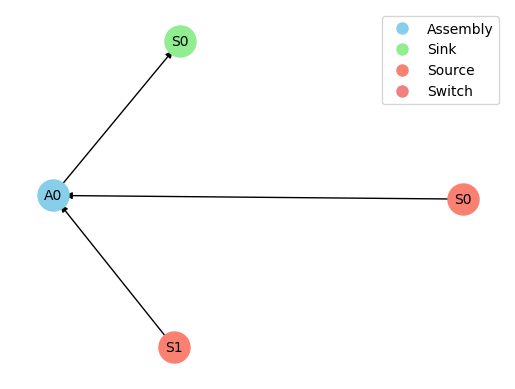

In [25]:
G = hetero_to_networkx(data)

# Layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes with type labels
node_colors = {
    'Assembly': 'skyblue',
    'Sink': 'lightgreen',
    'Source': 'salmon',
    'Switch': 'lightcoral'
}
for node_type in data.node_types:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n[0] == node_type],
        node_color=node_colors[node_type],
        label=node_type,
        node_size=500
    )

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={n: f"{n[0][0]}{n[1]}" for n in G.nodes}, font_size=10)

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Assembly', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sink', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Source', markerfacecolor='salmon', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Switch', markerfacecolor='lightcoral', markersize=10)
])
plt.axis('off')
plt.show()


---
### Generate by reading the Json file
---

In [26]:
import json
import re
from typing import Dict, Any, Optional
from lineflow.simulation import Source, Sink, Assembly, Line

class LineGenerator:
    """
    Generate production lines from JSON configuration files
    """
    
    def __init__(self):
        self.component_registry = {
            'Source': Source,
            'Sink': Sink,
            'Assembly': Assembly,
            'WTAssembly': WTAssembly,  # Custom components
        }
        
    def register_component(self, name: str, component_class):
        """Register custom component types"""
        self.component_registry[name] = component_class
    
    def load_from_json(self, json_path: str, **override_params) -> 'GeneratedLine':
        """
        Load line configuration from JSON file
        
        Args:
            json_path: Path to JSON configuration file
            **override_params: Parameters to override from JSON
        """
        with open(json_path, 'r') as f:
            config = json.load(f)
        
        return self.create_line_from_config(config, **override_params)
    
    def create_line_from_config(self, config: Dict[str, Any], **override_params) -> 'GeneratedLine':
        """
        Create line from configuration dictionary
        """
        # Extract line parameters
        line_config = config.get('line_config', {})
        line_params = line_config.get('parameters', {})
        
        # Override with provided parameters
        line_params.update(override_params)
        
        # Create the line class
        line = GeneratedLine(config, line_params)
        
        return line
    
    def _resolve_parameter_references(self, value: Any, params: Dict[str, Any]) -> Any:
        """
        Resolve parameter references like "${processing_time_source}"
        """
        if isinstance(value, str) and value.startswith('${') and value.endswith('}'):
            param_name = value[2:-1]
            return params.get(param_name, value)
        elif isinstance(value, list):
            return [self._resolve_parameter_references(item, params) for item in value]
        elif isinstance(value, dict):
            return {k: self._resolve_parameter_references(v, params) for k, v in value.items()}
        else:
            return value

class GeneratedLine(Line):
    """
    Dynamically generated production line from JSON configuration
    """
    
    def __init__(self, config: Dict[str, Any], line_params: Dict[str, Any], **kwargs):
        self.config = config
        self.line_params = line_params
        self.generator = LineGenerator()
        
        # Initialize Line base class
        super().__init__(**kwargs)
    
    def build(self):
        """
        Build the line from JSON configuration
        """
        self.graph_info = {
            'nodes': {},
            'edges': [],
            'metadata': self.config.get('line_config', {})
        }
        
        # Create components
        components = {}
        node_configs = self.config.get('nodes', {})
        
        for node_name, node_config in node_configs.items():
            # Resolve parameter references
            resolved_config = self.generator._resolve_parameter_references(
                node_config, self.line_params
            )
            
            component = self._create_component(node_name, resolved_config)
            components[node_name] = component
            
            # Record node info for graph
            self.graph_info['nodes'][node_name] = resolved_config
        
        # Create connections
        edge_configs = self.config.get('edges', [])
        
        for edge_config in edge_configs:
            # Resolve parameter references
            resolved_edge = self.generator._resolve_parameter_references(
                edge_config, self.line_params
            )
            
            self._create_connection(components, resolved_edge)
            
            # Record edge info
            self.graph_info['edges'].append(resolved_edge)
        
        # Store components
        self.components = components
    
    def _create_component(self, name: str, config: Dict[str, Any]):
        """
        Create a component from configuration
        """
        component_type = config.get('type')
        if component_type not in self.generator.component_registry:
            raise ValueError(f"Unknown component type: {component_type}")
        
        # Extract constructor parameters
        constructor_params = {k: v for k, v in config.items() 
                            if k not in ['type', 'properties']}
        constructor_params['name'] = name
        
        # Create component
        component_class = self.generator.component_registry[component_type]
        component = component_class(**constructor_params)
        
        return component
    
    def _create_connection(self, components: Dict[str, Any], edge_config: Dict[str, Any]):
        """
        Create connections between components
        """
        source_name = edge_config['source']
        target_name = edge_config['target']
        connection_type = edge_config.get('connection_type', 'standard_input')
        
        source_component = components[source_name]
        target_component = components[target_name]
        
        # Extract connection parameters
        connection_params = {k: v for k, v in edge_config.items() 
                           if k not in ['source', 'target', 'connection_type', 'properties']}
        
        # Create connection based on type
        if connection_type == 'component_input':
            target_component.connect_to_component_input(
                station=source_component,
                **connection_params
            )
        elif connection_type == 'standard_input':
            target_component.connect_to_input(
                source_component,
                **connection_params
            )
        else:
            raise ValueError(f"Unknown connection type: {connection_type}")

In [ ]:
# Create line generator
generator = LineGenerator()

line = generator.load_from_json('waiting_time_config.json')

# Use the generated line
data = get_line_graph(line, format='heterodata')
print("Generated line:", data)

Generated line: HeteroData(
  Source={ x=[2, 4] },
  Assembly={ x=[1, 4] },
  Sink={ x=[1, 4] },
  (Source, connects_to, Assembly)={ edge_index=[2, 2] },
  (Assembly, connects_to, Sink)={ edge_index=[2, 1] }
)


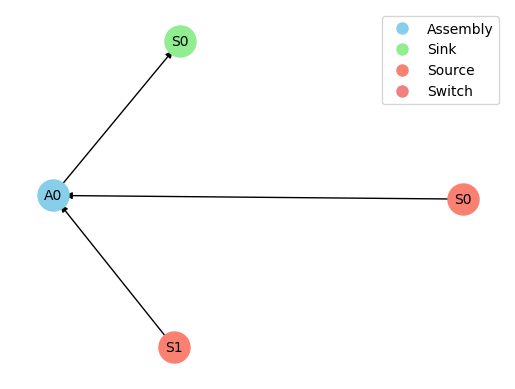

In [30]:
G = hetero_to_networkx(data)

# Layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes with type labels
node_colors = {
    'Assembly': 'skyblue',
    'Sink': 'lightgreen',
    'Source': 'salmon',
    'Switch': 'lightcoral'
}
for node_type in data.node_types:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n[0] == node_type],
        node_color=node_colors[node_type],
        label=node_type,
        node_size=500
    )

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={n: f"{n[0][0]}{n[1]}" for n in G.nodes}, font_size=10)

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Assembly', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sink', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Source', markerfacecolor='salmon', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Switch', markerfacecolor='lightcoral', markersize=10)
])
plt.axis('off')
plt.show()

---